# Training del modello


Dopo aver preparato i dati e definito l'architettura della rete neurale, vado ad addestrare il modello. Durante il training il modello diventerà in grado di riconoscere i pattern e fare previsioni sulle maschere di nuovi dati.

Il processo di training avviene iterativamente per epoche. Per ogni epoca si svolgono le seguenti operazioni:
- viene eseguita la funzione train() sul training set, il modello apprenderà dati, calcolerà la loss e aggiornerà i pesi per minimizzare l'errore;
- viene eseguita la funzione get_evals() sul validation set, cioè vengono calcolate diverse metrice di performance (loss, precision, recall, F1-score) per valutare quanto il modello che sto addestrando è in grado di generalizzare su dati non visti;
- vengono salvate le metriche di valutazione e di training nel dizionario history per monitorare l'andamento delle prestazioni nel tempo;
- viene eseguito un check per prevenire l'overfitting, detto early stopping, che interrompe in anticipo l'addestramento se la loss calcolata sul validation set non migliora o peggiora per un certo numero di iterazioni.

In [2]:
# Let's import our own modules
import sys
sys.path.insert(0, './src')
import utils

import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning

Verifico che la GPU sia disponibile e che CUDA funzioni.

In [30]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())

Using PyTorch version: 2.7.1+cu118  Device: cuda
PyTorch version:  2.7.1+cu118
CUDA version:  11.8
cuDNN version:  90100


Costanti utili e percorsi utili

In [4]:
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-4
MAX_LR = 1e-2
SIZE = 200
NUM_WORKERS = 8
BATCH_SIZE = 16 # o 32
EPOCHS = 16
LOAD_BEST = False

# Percorsi utili
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"
SPLIT_PATH = "split/"

Preparo i dati e faccio data augmentation prima di iniziare ad addestrare la rete. Utilizzo la libreria Albumentations, come suggerito dal tutor, che è molto efficiente nelle trasformazioni delle immagini.

Per il training set vado a fare una normalizzazione dei pixel delle immagini e poi vado a fare dei Random Resized Crop, cioè faccio selezionare una porzione casuale dell'immagine, che viene poi ridimensionata alla dimensione SIZE.

Per il validation set vado a fare una normalizzazione dei pixel delle immagini e poi vado a fare dei Center Crop, cioè faccio selezionare una porzione quadrata di lato SIZE dal centro dell'imagine.

Infine vado a caricare le immagini e le maschere del dataset, applicandovi le trasformazioni definite nella stessa cella.

In [32]:
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomResizedCrop(size = (SIZE, SIZE)),
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(SIZE, SIZE)
])

from dataset import SpaceNet6Dataset

train_dataset = SpaceNet6Dataset(SPLIT_PATH, transform=train_transforms, split='train')
eval_dataset = SpaceNet6Dataset(SPLIT_PATH, transform=eval_transforms, split='val')

Vado a caricare sui loader i valori necessari per l'addestramento che sono i dataset, le dimensioni dei batch, la funzione shuffle per mescolare i dati, la variabile pin_memory così che PyTorch tenta di caricare i tensori nella memoria "pinnata" (pinned memory) della RAM e il numero di sottoprocessi da utilizzare per il caricamento dei dati.
Infine faccio un check di prova stampando un'immagine casuale e la rispettiva maschera.

Image shape: torch.Size([16, 3, 200, 200]), Mask shape: torch.Size([16, 1, 200, 200])


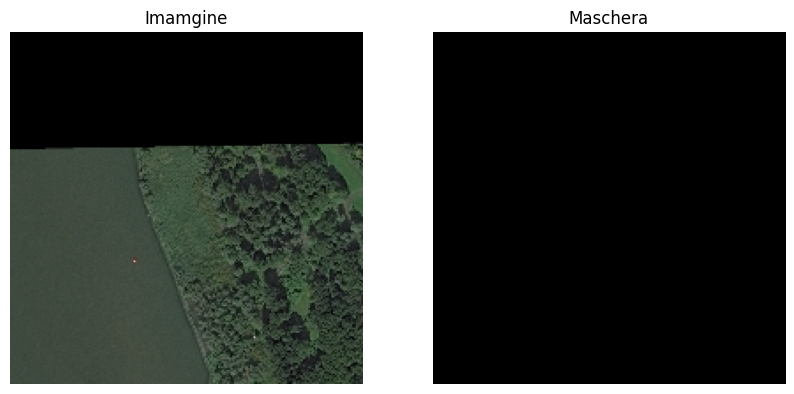

In [33]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True, num_workers=NUM_WORKERS)

    image, mask = next(iter(train_loader))
    in_channels = image.shape[1]
    out_channels = mask.shape[1]
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    utils.visualize_image(image[0], mask[0])

In [34]:
mean, std = utils.get_mean_std("split/train.txt")
print("Mean: ", mean)
print("Std: ", std) 

Using device: cuda


Calculating mean and std: 100%|██████████| 2720/2720 [00:20<00:00, 130.61it/s]

Mean:  [63.31486282 66.9413639  60.9381894 ]
Std:  [55.64725704 55.50469196 52.78288904]


Importo il modello che contiene la rete e vado a stabilire diversi parametri necessari, come la funzione di loss da utilizzare, il tipo di ottimizzatore da utilizzare e se utilizzare uno scaler.

In [35]:
from model import UNET
from train import train
from torchsummary import summary
import torch.optim as optim

model = UNET(in_channels = 3, out_channels = 1).to(device)

loss_f = nn.BCEWithLogitsLoss() # All'inizio usiamo BCEWithLogitsLoss, poi provo anche una CrossEntropyLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-4)

scheduler = None
scaler = torch.amp.GradScaler('cuda', enabled=True)

print("Riepilogo del modello:")
summary(model, input_size=(in_channels, SIZE, SIZE), device=str(device))

print("Modello U-Net inizializzato e spostato sul dispositivo.")

# Ricorda di dare un nome al modello ad ogni esecuzione, che lo identificherà nel file riassuntivo
model_name = "UNET_2"

Riepilogo del modello:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,728
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
            Conv2d-4         [-1, 64, 200, 200]          36,864
       BatchNorm2d-5         [-1, 64, 200, 200]             128
              ReLU-6         [-1, 64, 200, 200]               0
        DoubleConv-7         [-1, 64, 200, 200]               0
         MaxPool2d-8         [-1, 64, 100, 100]               0
            Conv2d-9        [-1, 128, 100, 100]          73,728
      BatchNorm2d-10        [-1, 128, 100, 100]             256
             ReLU-11        [-1, 128, 100, 100]               0
           Conv2d-12        [-1, 128, 100, 100]         147,456
      BatchNorm2d-13        [-1, 128, 100, 100]             256
             ReL

Avvio il training del mio modello.

In [36]:
# Variabili per i checkpoint
best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
}

last_epoch = 0
if LOAD_BEST:
    print("Ricaricando il modello migliore...")
    if(os.path.exists(CHECKPOINT_PATH + "best.pth")):
        history, last_epoch = utils.load_checkpoint(CHECKPOINT_PATH + "best.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
    else:
        print("Nessun modello trovato, inizio un nuovo training da zero.")


# Ciclo di traininig
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    for epoch in range(last_epoch, EPOCHS):
        print(f"Epoch {epoch+1} of {EPOCHS}")
        train_loss = train(train_loader, model, optimizer, loss_f, scaler, scheduler, device)
        # Se la loss è NaN, vuol dire che qualcosa non sta andando come previsto, vado quindi ad interrompere il training.
        # in python il controllo se una variabile è NaN si fa con la condizione `var != var`
        if train_loss != train_loss:
            raise ValueError("La loss è Nan, qualcosa sta andando storto, interrompo il training!")

        eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, loss_f, device, save_predictions=True, output_path="data/eval/" + model_name + "/")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(eval_loss)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        history['accuracy'].append(accuracy)
        print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
        # Salvataggio del checkpoint
        checkpoint = {
            "history" : history,
            "epoch" : epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss_f.state_dict(),
        }
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "checkpoint.pth")
        if f1 > best_f1:
            best_f1 = f1
            utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "best.pth")
            print("Best model salvato")

        if epoch - 3 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
            if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2]:
                print("Early stopping")
                break
print("Training completato con successo!")

Epoch 1 of 16


Loss: 0.4814: 100%|██████████| 170/170 [00:39<00:00,  4.26it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.5800 Eval loss: 0.5131 Precision: 0.2650 Recall: 0.1505 F1: 0.1920 Accuracy: 0.8660
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Epoch 2 of 16


Loss: 0.3729: 100%|██████████| 170/170 [00:51<00:00,  3.28it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.4182 Eval loss: 0.4097 Precision: 0.3254 Recall: 0.0494 F1: 0.0857 Accuracy: 0.8886
Salvataggio del checkpoint
Epoch 3 of 16


Loss: 0.3114: 100%|██████████| 170/170 [02:31<00:00,  1.12it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.3434 Eval loss: 0.3592 Precision: 0.3288 Recall: 0.0251 F1: 0.0466 Accuracy: 0.8915
Salvataggio del checkpoint
Epoch 4 of 16


Loss: 0.2590: 100%|██████████| 170/170 [00:43<00:00,  3.95it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2976 Eval loss: 0.3257 Precision: 0.3305 Recall: 0.0192 F1: 0.0363 Accuracy: 0.8921
Salvataggio del checkpoint
Epoch 5 of 16


Loss: 0.2336: 100%|██████████| 170/170 [02:47<00:00,  1.01it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2722 Eval loss: 0.3030 Precision: 0.3382 Recall: 0.0196 F1: 0.0370 Accuracy: 0.8922
Salvataggio del checkpoint
Epoch 6 of 16


Loss: 0.2664: 100%|██████████| 170/170 [01:13<00:00,  2.33it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2537 Eval loss: 0.2858 Precision: 0.3392 Recall: 0.0166 F1: 0.0317 Accuracy: 0.8926
Salvataggio del checkpoint
Epoch 7 of 16


Loss: 0.2584: 100%|██████████| 170/170 [01:29<00:00,  1.89it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2397 Eval loss: 0.2752 Precision: 0.3574 Recall: 0.0182 F1: 0.0347 Accuracy: 0.8927
Salvataggio del checkpoint
Epoch 8 of 16


Loss: 0.1782: 100%|██████████| 170/170 [02:11<00:00,  1.29it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2279 Eval loss: 0.2685 Precision: 0.4187 Recall: 0.0322 F1: 0.0598 Accuracy: 0.8929
Salvataggio del checkpoint
Epoch 9 of 16


Loss: 0.1823: 100%|██████████| 170/170 [00:59<00:00,  2.88it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2188 Eval loss: 0.2599 Precision: 0.4951 Recall: 0.0477 F1: 0.0870 Accuracy: 0.8941
Salvataggio del checkpoint
Epoch 10 of 16


Loss: 0.1778: 100%|██████████| 170/170 [03:01<00:00,  1.07s/it]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2123 Eval loss: 0.2533 Precision: 0.5585 Recall: 0.0740 F1: 0.1307 Accuracy: 0.8959
Salvataggio del checkpoint
Epoch 11 of 16


Loss: 0.1713: 100%|██████████| 170/170 [00:42<00:00,  4.02it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2095 Eval loss: 0.2463 Precision: 0.5953 Recall: 0.1193 F1: 0.1988 Accuracy: 0.8983
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Epoch 12 of 16


Loss: 0.2085: 100%|██████████| 170/170 [03:01<00:00,  1.07s/it]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.2016 Eval loss: 0.2449 Precision: 0.5987 Recall: 0.1327 F1: 0.2173 Accuracy: 0.8989
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Epoch 13 of 16


Loss: 0.1894: 100%|██████████| 170/170 [00:42<00:00,  4.00it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.1967 Eval loss: 0.2451 Precision: 0.6101 Recall: 0.1805 F1: 0.2786 Accuracy: 0.9011
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Epoch 14 of 16


Loss: 0.2414: 100%|██████████| 170/170 [02:43<00:00,  1.04it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.1939 Eval loss: 0.2410 Precision: 0.6102 Recall: 0.1961 F1: 0.2968 Accuracy: 0.9017
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Epoch 15 of 16


Loss: 0.2198: 100%|██████████| 170/170 [02:07<00:00,  1.33it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.1907 Eval loss: 0.2415 Precision: 0.6119 Recall: 0.1931 F1: 0.2935 Accuracy: 0.9017
Salvataggio del checkpoint
Epoch 16 of 16


Loss: 0.1821: 100%|██████████| 170/170 [01:03<00:00,  2.66it/s]

Predizioni salvate in: data/eval/UNET_2/


Train loss: 0.1887 Eval loss: 0.2390 Precision: 0.6128 Recall: 0.2242 F1: 0.3282 Accuracy: 0.9030
Salvataggio del checkpoint
Salvataggio del checkpoint
Best model salvato
Training completato con successo!


In [37]:
SUMMARY_FILE_PATH = "output/stats/riassunto_modelli.txt"
epochs_completed = epoch + 1 # Poiché 'epoch' è 0-indexed
final_train_loss = history['train_loss'][-1] # L'ultimo elemento della lista
final_eval_loss = history['val_loss'][-1]   # L'ultimo elemento della lista
loss_function_name = loss_f.__class__.__name__

# Trova l'epoca in cui è stato raggiunto il best_f1
try:
    if history['f1']:
        best_f1_epoch = history['f1'].index(best_f1)
    else:
        best_f1_epoch = 0 # Se la history è vuota, usa 0
except ValueError:
    best_f1_epoch = epochs_completed - 1 if epochs_completed > 0 else 0
    print(f"Attenzione: Impossibile trovare best_f1 ({best_f1:.4f}) nella cronologia. Usando l'epoca {best_f1_epoch} per le metriche.")


final_precision = history['precision'][best_f1_epoch]
final_recall = history['recall'][best_f1_epoch]
final_accuracy = history['accuracy'][best_f1_epoch]

# Prepara le stringhe per configurazione e statistiche
config_str = (
    f"MODEL_NAME={model_name},"
    f"NETWORK_TYPE=UNET,IN_CHANNELS={in_channels},OUT_CHANNELS={out_channels},"
    f"LR={INITIAL_LR},BATCH_SIZE={BATCH_SIZE},OPTIMIZER=Adam,"
    f"LOSS_FUNCTION={loss_function_name}," 
    f"MAX_EPOCHS={EPOCHS}"  
    # Altri parametri da aggiungere
)

stats_str = (
    f"TRAIN_LOSS={final_train_loss:.4f},"
    f"VAL_LOSS={final_eval_loss:.4f},"
    f"BEST_F1={best_f1:.4f},"
    f"PRECISION={final_precision:.4f},"
    f"RECALL={final_recall:.4f},"
    f"ACCURACY={final_accuracy:.4f},"
    f"EPOCH_OF_BEST_F1={best_f1_epoch}" # Aggiungi l'epoca del best F1
    # Altri parametri da aggiungere
)

# Scrittura sul file di riepilogo
with open(SUMMARY_FILE_PATH, 'a') as f:
    f.write(f"# --- INIZIO RUN: {model_name} ---\n")
    f.write(f"Config: {config_str}\n")
    f.write(f"Stats: {stats_str}\n")
    f.write(f"# --- FINE RUN: {model_name} ---\n\n")

print(f"Riepilogo del run '{model_name}' salvato in '{SUMMARY_FILE_PATH}'")

Riepilogo del run 'UNET_2' salvato in 'output/stats/riassunto_modelli.txt'


Vado infine a stampare un esempio di predizione e di ground truth (maschera effettiva). Seguono i grafici sull'andamento della funzione di loss e delle varie metriche di valutazione, all'aumentare delle epoche passate.

In [5]:
import matplotlib.pyplot as plt

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    
    # Visualizzazione di un esempio di predizione e ground truth
    history = utils.load_checkpoint(CHECKPOINT_PATH + "checkpoint.pth", model)
    image, mask, pred = utils.get_random_image(eval_loader, model, device)
    utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + "esempio.png")

    train_loss = history['train_loss']
    eval_loss = history['val_loss']
    precision = history['precision']
    recall = history['recall']
    accuracy = history['accuracy']
    f1_score = history['f1']
    # Grafico della loss e delle altre metriche di valutazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Eval Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Metriche di valutazione')
    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(accuracy, label='Accuracy')
    plt.plot(f1_score, label='F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(GRAPH_PATH + "grafico.png")
    plt.show()

NameError: name 'model' is not defined